This notebook presents a CNN-based plant disease detection model trained on images from four categories: Potato__Late_blight, Potato__Early_blight, Pepper__bell___Healthy, and Pepper__bell___Bacterial_spot. The data was preprocessed by resizing, batching, and normalizing the images. I applied optimization techniques such as dropout, the Adam optimizer, early stopping, and hyperparameter tuning using Keras Tuner. The model was evaluated using accuracy, loss, precision, recall, and F1-score. Finally, it was tested on a sample image and the best-performing model was saved for future use.

Install Keras Tuner

In [1]:
!pip install keras-tuner --quiet



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Imports libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report
import keras_tuner as kt


## Data Preprocessing 

- Images loaded from folders using `image_dataset_from_directory` with size 128x128 pixels.
- Training data shuffled and batched with size 32.
- Pixel values normalized from [0, 255] to [0, 1] using a rescaling layer.
- Class labels extracted automatically.
- Sample images visualized to verify correctness.


Load and Prepare Data

In [3]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dir = "data/train"
val_dir = "data/test"

print("Loading training data...")
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.0,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Loading validation data...")
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Normalize images
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Loading training data...
Found 3908 files belonging to 4 classes.
Loading validation data...
Found 3908 files belonging to 4 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight']


Visualize Sample Images

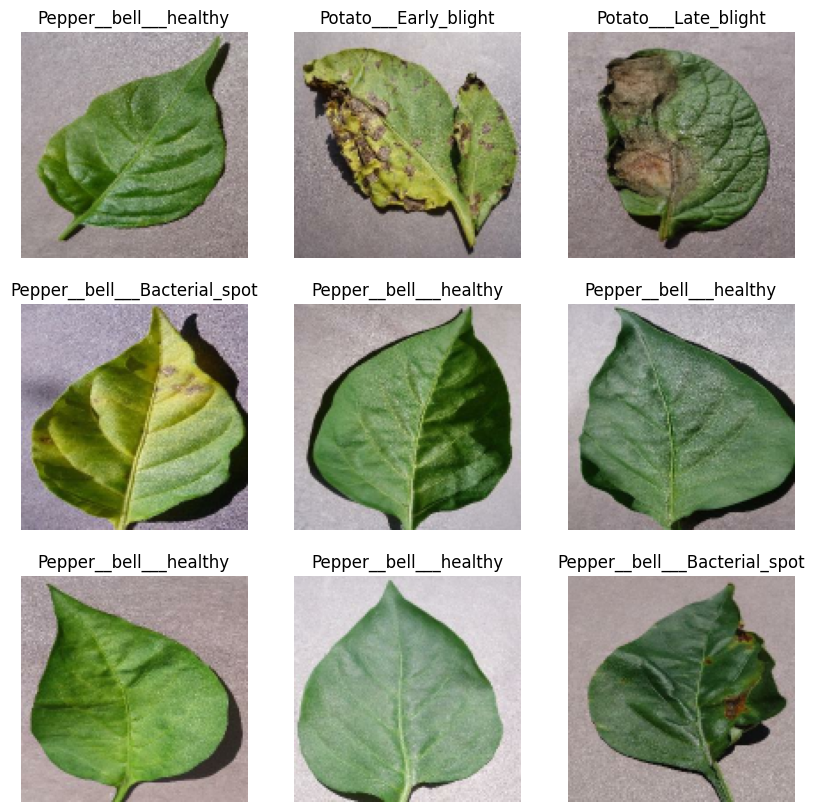

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


##  Optimization Techniques Used

- **Adam optimizer** with tunable learning rate.
- **Dropout** layer to reduce overfitting.
- **Early stopping** to stop training when validation loss stops improving.
- **Hyperparameter tuning** to find the best model architecture and learning rate using Keras Tuner.


Define Model Building Function for Hyperparameter Tuning

In [5]:
def build_model(hp):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(*IMG_SIZE, 3)))

    # Tune number of filters in convolutional layers
    for i in range(3):
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i}_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3,3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    # Tune number of units in dense layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))

    # Tune dropout rate
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Tune learning rate for Adam optimizer
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Run Hyperparameter Tuning

In [8]:
model = models.Sequential([
    layers.InputLayer(input_shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[stop_early])


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.5481 - loss: 1.0550 - val_accuracy: 0.8332 - val_loss: 0.4113
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.8405 - loss: 0.4367 - val_accuracy: 0.9015 - val_loss: 0.2531
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - accuracy: 0.8815 - loss: 0.3291 - val_accuracy: 0.8710 - val_loss: 0.3312
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - accuracy: 0.9131 - loss: 0.2643 - val_accuracy: 0.9639 - val_loss: 0.1150
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - accuracy: 0.9525 - loss: 0.1367 - val_accuracy: 0.9857 - val_loss: 0.0476
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.9707 - loss: 0.1099 - val_accuracy: 0.9913 - val_loss: 0.0303
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - accuracy: 0.9762 - loss: 0.0983 - val_accuracy: 0.9980 - val_loss: 0.0161
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.9795 - loss: 0

Retrieve Best Model and Train

In [9]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

best_model = tuner.hypermodel.build(best_hp)

history = best_model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[stop_early])


Best hyperparameters: {'conv_0_filters': 32, 'conv_1_filters': 32, 'conv_2_filters': 32, 'dense_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0012967304114198843, 'tuner/epochs': 4, 'tuner/initial_epoch': 2, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0010'}
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.5811 - loss: 0.9580 - val_accuracy: 0.8309 - val_loss: 0.4184
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.8519 - loss: 0.4164 - val_accuracy: 0.9107 - val_loss: 0.2931
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.8932 - loss: 0.2981 - val_accuracy: 0.9560 - val_loss: 0.1553
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.9242 - loss: 0.2288 - val_accuracy: 0.9184 - val_loss: 0.2226
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9407 - loss: 0.1729 - val_accuracy: 0.9452 - val_loss: 0.1292
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/s

 Plot Training Accuracy and Loss

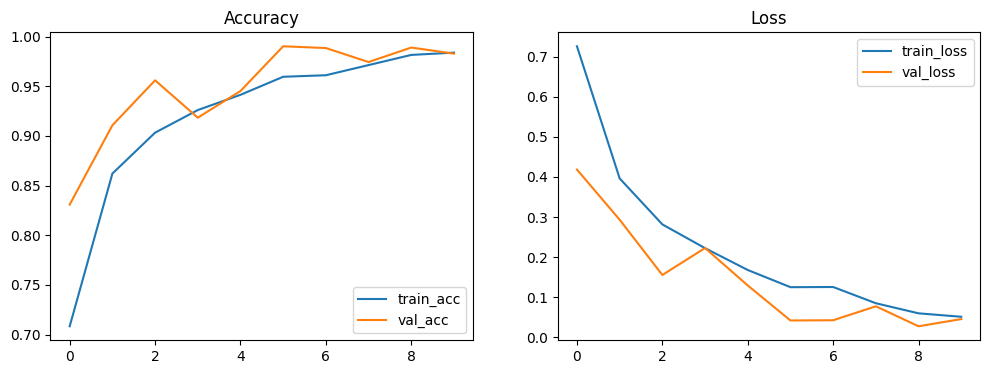

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.show()


## Model Evaluation Metrics
I evaluated the model using these metrics:

- Accuracy  
- Loss (sparse categorical crossentropy)  
- Precision  
- Recall  
- F1 Score  

These metrics provide a well-rounded evaluation of the model’s performance.


Generate Evaluation Metrics on Validation Set

In [12]:
# Convert val_ds into full batched arrays
y_true = []
y_pred = []

for batch_images, batch_labels in val_ds:
    preds = best_model.predict(batch_images, verbose=0)
    batch_preds = np.argmax(preds, axis=1)

    y_pred.extend(batch_preds)
    y_true.extend(batch_labels.numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.99      1.00      1.00       997
       Pepper__bell___healthy       0.99      1.00      1.00      1478
        Potato___Early_blight       0.97      1.00      0.99      1000
         Potato___Late_blight       1.00      0.91      0.95       433

                     accuracy                           0.99      3908
                    macro avg       0.99      0.98      0.98      3908
                 weighted avg       0.99      0.99      0.99      3908



Prediction Function on Single Image

In [13]:
def preprocess_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(model, img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)[0]
    top_idx = np.argmax(predictions)
    confidence = predictions[top_idx]
    class_name = class_names[top_idx]
    return class_name, confidence

sample_image_path = "data/test/Potato___Late_blight/00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.jpg"
predicted_class, confidence = predict_image(best_model, sample_image_path)
print(f"Prediction: {predicted_class} (Confidence: {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Potato___Late_blight (Confidence: 1.00)


Save Best Model

In [14]:
MODEL_PATH = "models/plant_disease_model_tuned.keras"
best_model.save(MODEL_PATH)
print(f"Model saved at {MODEL_PATH}")


Model saved at models/plant_disease_model_tuned.keras
